# Imagined Handwriting


## Background
This work is based on the paper [High-performance brain-to-text communication via handwriting](https://www.nature.com/articles/s41586-021-03506-2) (Willett et al., 2021).  In that paper the authors demonstrate that it is possible to decode characters via imagined handwriting with an intracortical Brain Computer Interface (BCI).   Importantly, they were able to achieve state-of-the-art typing speeds (~90 characters per minute) with good online accuracy.

## Our Approach
We replaced the RNN decoder used in the original paper with an [FNet Transformer](https://arxiv.org/abs/2105.03824).  The choice to use FNet was made so the transformer model could learn efficiently from very long sequences, but is not strictly necessary when using the transformer in a "rolling window" manner.  In addition, we incorporate a language model and a dictionary restriction to our beam search which allows us to use the language model in [real-time](https://twitter.com/AEStudioLA/status/1575139698779082752?s=20), ultimately improving the character error rate for the live system<a name="ref1"></a>[<sup>1</sup>](#footnote1).   The language model we use is identical to the bigram language model released with the [data associated with paper](https://datadryad.org/stash/dataset/doi:10.5061/dryad.wh70rxwmv) with the exception that we add probabilities for unknown words (see below).

## Setup
To successfully run this notebook you must first execute `run_full_experiment.py` (see the instructions in the README).  This will pretrain a transformer model on the first 3 sessions of data and then fine-tune that model on the remaining sessions.  This pretrain/finetune approach is similar to the approach used in the paper for real-time closed loop decoding (the authors fine-tuned a model in-session after a collecting calibration data).  We limit our fine-tuning to 2000 training steps so that it executes fast enough that it is possible to run it "in-session" for a fair comparison.

Additionally, you will need to manually update the language model according to the instructions in the README.  In summary, to execute this notebook you need

1. To execute `run_full_experiment.py`
1. Update the bigram language model that comes packaged with the data 

See the README for further details on both those steps.


<a name="footnote1"></a>[[1]](#ref1) All our analysis is run offline but the original experiment was run online with closed loop decoding.  Since the user needs to complete a full character movement before getting feedback, the offline open loop decoding may be a good approximation of what can be expected online.

---------
## Model Path

Update the path below to indicate the [MLFlow](https://github.com/mlflow/mlflow) directory this notebook should use for its models.  This directory will have been created automatically for you when you execute `run_full_experiment.py` and it should be fine to leave the default value provided below, except in the case where you execute the experiment more than once, in which case you will need to update to the correct folder by incrementing the experiment id number (the folder number).

In [1]:
EXPERIMENT_ID = 1
MLFLOW_DIR = f"mlruns/{EXPERIMENT_ID}"

--------
## Imports

In [2]:
from pathlib import Path
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import re

import torch

from imagined_handwriting.datasets import HandwritingDataModule
from imagined_handwriting.models.lightning_model import HandwritingTransformerExperiment
from imagined_handwriting.inference import SlidingWindowDecoder
from imagined_handwriting.metrics import TextEvaluator
from imagined_handwriting.inference.beam_search import decode, Tokenizer
from imagined_handwriting.data import load_raw


import pygtrie
import kenlm


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

----
### Load models and data from the fine-tuning runs

In [3]:
datamodules = {}
models = {}

for ckpt_file in Path(MLFLOW_DIR).glob('**/last.ckpt'):
    ckpt = torch.load(ckpt_file)
    session = sorted(ckpt['datamodule_hyper_parameters']['session_ids'])[-1]
    if not ckpt['datamodule_hyper_parameters']['pretrain']:
        datamodules[session] = HandwritingDataModule.load_from_checkpoint(ckpt_file, session_ids=[session], root='data')
        model = HandwritingTransformerExperiment.load_from_checkpoint(ckpt_file)
        model.to(DEVICE)
        model.eval()
        models[session] = SlidingWindowDecoder(model, window_size=200, stride=100, prediction_start=50)

-----
### Use the models to get predictions and convert to CTC

The model predicts a "character start signal" which is near 1 when the model believes a new character has started and near 0 otherwise.  It also predicts a softmax probability distribution over the possible characters.  To decode *without* a language model and beam search we would simply pick the most likely character when the start signal crossed a certain threshold (i.e. pick the most likely character when the model is confident a new character has started).  

For the beam search, however, it is useful to have a [CTC](https://distill.pub/2017/ctc/) output.  Since we don't start with a CTC output, we manually convert our start signal and character probabilities to a CTC like signal.  We follow the same approach as Willett et. al but slightly modify the parameters for "sharper" outputs.  See the [supplemental material, pg 40](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03506-2/MediaObjects/41586_2021_3506_MOESM1_ESM.pdf ) for details.

In [4]:
def logits_to_ctc(logits_start, logits_char):
    """Converts logits to CTC format
    
    This is described in detail in the supplemental material, pg 40.

    See:
        https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03506-2/MediaObjects/41586_2021_3506_MOESM1_ESM.pdf 
    """
    char_proba = scipy.special.softmax(logits_char, axis=-1)
    blank_proba = np.ones(logits_start.shape)

    # 1 - sigmoid(100 + 100*logits_start) + a 10 timestep delay.
    blank_proba[:,10:] = 1-scipy.special.expit(100 + 100*logits_start[:,0:-10])
    blank_proba = blank_proba.reshape(blank_proba.shape + (1,))
    # put blank first (different from willett and kaldi)
    combined = np.concatenate([blank_proba, char_proba], axis=-1) # (batch_size, seq_len, n_char+1)
    combined[:,:, 1:] *= 1-blank_proba # rescale so sum of character probs = 1
    combined[combined==0] = 1e-12
    
    return combined

In [5]:
ctc = {}
text = {} 
end_of_sentence_index = {}

for session, dm in datamodules.items():
    dm.prepare_data()
    dm.setup('test')
    test_dl = dm.test_dataloader()[0]
    all_logits_start = []
    all_logits_char = []
    all_text = [] 
    all_end_of_sentence_index = []
    for batch in test_dl:
        with torch.no_grad():
            x = batch['x'].to(DEVICE)
            session_id = batch['session_id']
            logits_start, logits_char = models[session](x, session_id=session_id)
            all_logits_start.append(logits_start.cpu().numpy())
            all_logits_char.append(logits_char.cpu().numpy())
            all_text.extend(batch['text'])
            all_end_of_sentence_index.extend(batch['end_of_sentence_index'].tolist())
    all_logits_start = np.concatenate(all_logits_start)
    all_logits_char = np.concatenate(all_logits_char)
    ctc_signal = logits_to_ctc(logits_start.cpu().numpy(), logits_char.cpu().numpy())
    ctc[session] = ctc_signal
    text[session] = all_text
    end_of_sentence_index[session] = all_end_of_sentence_index

            
        

------
## Dictionary Restricted Search

We explicitly restrict our beam search to only decode words in our vocabulary.  We do this by creating a [trie](https://en.wikipedia.org/wiki/Trie#:~:text=In%20computer%20science%2C%20a%20trie,key%2C%20but%20by%20individual%20characters.) data structure which holds our words and then searching a proposed prefix for a word completion.  If there is no completion of the prefix in the trie then we give this prefix 0 probability so that our beam search will not select it.

For example, the prefix `lear` will have a completion `learn` (among others) so this prefix will have non-zero probability.  However the prefix `learnu` is not a word and does not have a completion to a word so will be assigned 0 probability.  

In [6]:
def load_trie(root='data', path=None):
    """Load a trie from a vocabulary file.
    
    Args:
        root (str): The root directory of the data download.  This is the 
            same directory used by the HandwritingDataModule and HandwritingDownload
            and defaults to 'data'.   If you downloaded the data a different way,
            it's best to specify the path to the vocabulary file directly.  If
            path is not None this will be ignored
        path (str): The path to the vocabulary file.  If None, the default
            vocabulary file will be used (assuming the data was downloaded with
            the imagined handwriting packaged to the <root> directory)

    Returns:
        pygtrie.CharTrie: A trie containing the vocabulary
    """
    trie = pygtrie.CharTrie()
    if path is not None:
        with open(path) as f:
            for line in f:
                trie[line.strip()] = True
    else:
        from imagined_handwriting.settings import DOWNLOAD_DIR
        vocab_file = Path(root) / DOWNLOAD_DIR / "handwritingBCIData" / "BigramLM" / "voc-50000"
        try:
            with open(vocab_file) as f:
                for line in f:
                    trie[line.strip()] = True
        except FileNotFoundError:
            raise FileNotFoundError(f"Could not find vocabulary file at {str(vocab_file)}.  "
                                    "You can specify the path to the vocabulary file "
                                    "directly with the path argument.")

In [7]:
trie = load_trie()

---------
## Adding a Language model

We also add a bigram language model to our beam search.  The language model is used to score the likelihood of a sentence given bigram probabilities.  We use the bigram model that is released with the data associated to the paper with a minor modification: we add an explicit probability for unknown words.  See the instructions in the README for how to update the bigram language model.

In [8]:
def load_bigram_model(root="data", path=None):
    if path is not None:
        return kenlm.Model(path)
    else:
        from imagined_handwriting.settings import DOWNLOAD_DIR
        bigram_file = Path(root) / DOWNLOAD_DIR / "handwritingBCIData" / "BigramLM" / "webTextSentences_tokenized-2gram-50000.arpa"
        try:
            return kenlm.Model(str(bigram_file))
        except:
            raise ValueError(f"Bigram model not found at: {str(bigram_file)}")

In [9]:

bigram = load_bigram_model()

Loading the LM will be faster if you build a binary file.
Reading /home/mike/ae/bci/imagined-handwriting/data/ImaginedHandwriting/raw/handwritingBCIData/BigramLM/webTextSentences_tokenized-2gram-50000.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


-------
## Execute Beam Search Decoding

For each sentence, we print the ground truth, predicted text, character error rate (CER), and word error rate (WER).

In [10]:
def run_decode(ctc, text, beam_size=32, trie=trie, lm=bigram, lm_weight=0.2):
    text_evaluator = TextEvaluator()
    out = decode(np.log(ctc), beam_size=beam_size, trie=trie, tokenizer=Tokenizer(), lm=lm, lm_weight=lm_weight)
    text_pred = Tokenizer().decode(list(out[0]))
    text_pred = re.sub(r">+", r">", text_pred)
    print(text)
    print(text_pred)
    text_evaluator.update(text, text_pred)
    print(f"{text_evaluator.cer():.2%} {text_evaluator.wer():.2%}")
    print()
    return text_evaluator, text, text_pred


def get_test_sentence_index(raw, idx):
    return raw.test_index[idx]

def get_sentence_block_number(raw, idx):
    sentence_idx = get_test_sentence_index(raw, idx)
    return raw.sentence_blocks[sentence_idx]

In [11]:
rows = []
for session in sorted(ctc.keys()):
    print(session)
    raw = load_raw('data', session)
    for i in range(len(ctc[session])):
        eos = end_of_sentence_index[session][i]
        example_data = ctc[session][i, :eos:10]
        text_eval, _, text_pred = run_decode(example_data, text[session][i])
        rows.append({
            'session': session,
            'cer': text_eval.cer(),
            'wer': text_eval.wer(),
            'n_char_error': text_eval.n_char_error,
            'n_char': text_eval.n_char,
            'n_word_error': text_eval.n_word_error,
            'n_word': text_eval.n_word,
            'relative_index': i, 
            'sentence_index': get_test_sentence_index(raw, i),
            'block_index':get_sentence_block_number(raw, i),
            'text': text,
            'text_pred': text_pred,
        })
    print('='*80)
metrics = pd.DataFrame(rows)

t5.2019.12.11
the>quick>brown>fox>jumps>over>the>lazy>dog
the>quick>brown>fox>jumps>over>the>lady>dog
2.33% 11.11%

imagine>all>the>people>living>life>in>peace
imagine>all>the>people>living>life>in>peaae
2.33% 12.50%

ask>not>what>your>country>can>do>for>you
ask>not>what>your>country>enan>do>for>you
5.00% 11.11%

i>heard>my>friend>is>going>into>town>today
i>heard>my>friend>is>going>into>town>today
0.00% 0.00%

you>must>be>the>change>you>wish>to>see>in>the>world
you>must>be>the>change>you>wish>to>see>in>the>world
0.00% 0.00%

when>the>sunlight>strikes>raindrops>in>the>air
when>the>sunlight>strikes>raindrops>in>the>air
0.00% 0.00%

i>like>when>you>sit>with>me>and>read>the>paper
i>like>when>you>sit>with>me>and>read>the>paper
0.00% 0.00%

he>fumbled>in>the>pocket>of>his>jacket>with>stiff>frozen>fingers~
he>fumbled>in>the>pocket>of>his>jacket>with>stff>froren>fingers~
3.08% 16.67%

she>is>proud>and>wise>and>speaks>with>authority>of>many>things~
she>is>proud>and>wise>and>speaks>with>aauthori

------
## Results

We now plot the character error rate for each block of each session.  For comparison see [Figure 2c](https://www.nature.com/articles/s41586-021-03506-2/figures/2) of the [original paper](https://www.nature.com/articles/s41586-021-03506-2).

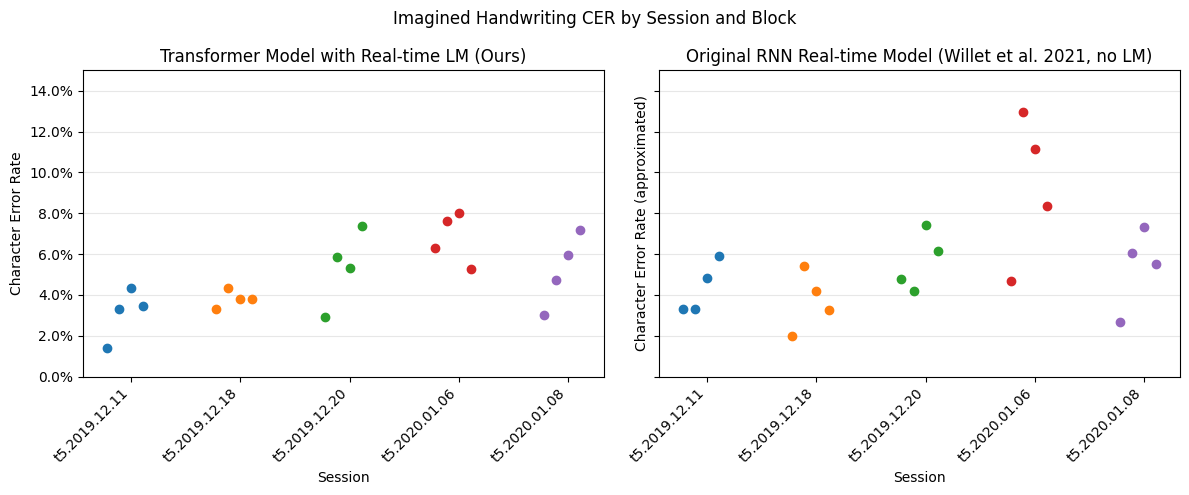

In [49]:
from matplotlib import ticker as mticker
willett_approx_results_df = pd.read_csv('assets/willett_2c_approx_cer.csv')
willett_approx_results = willett_approx_results_df['cer'].values

fig, axes = plt.subplots(1,2, figsize=(12, 5), sharey=True)

grp = metrics.groupby(['session', 'block_index'])[['cer', 'wer']].mean().reset_index().sort_values(by=['session', 'block_index'])


mids = []
start = 0
idx_start = 0
for session in grp.session.unique():
    cer = grp[grp['session']==session]['cer']
    stop = start + len(cer)
    idx_stop = idx_start + len(cer)
    willett_cer = willett_approx_results[idx_start:idx_stop]
    axes[0].scatter(range(start, stop), cer, zorder=3)
    axes[1].scatter(range(start, stop), willett_cer, zorder=3)
    mids.append((start + stop) // 2)
    start = stop + 5
    idx_start = idx_stop


for ax in axes:
    ax.set_xticks(mids, sorted(metrics['session'].unique()), rotation=45, ha='right')
    ax.set_xlabel('Session')
    ax.grid(axis='y', zorder=0, alpha=0.3)


ax = axes[0]
ax.set_ylim(0, .15)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_ylabel('Character Error Rate')
ax.set_title('Transformer Model with Real-time LM (Ours)')

ax = axes[1]
ax.set_title("Original RNN Real-time Model (Willett et al. 2021, no LM)")
ax.set_ylabel('Character Error Rate (approximated)')


fig.suptitle("Imagined Handwriting CER by Session and Block")
fig.tight_layout()




The figure shows the character error rate (CER) for our offline but real-time compatible beam search (left) and the original real-time CER results from Willett et al. (right).  Each dot represents the average CER over a block, there are 4 blocks per session.




Note the original results are approximated by [PlotDigitizer, 3.1.5, 2023](https://plotdigitizer.com)



-----
## Conclusion

Following the work of Willett et al. we've built a model which decodes characters from neural signals during imagined handwriting.  We've made the following changes, which we hope will be a launching point for future work from the community.

1. We replaced the RNN model with an FNet Transformer equipped with sliding window inference.
1. We implemented a simple but effective real-time beam search that includes a dictionary restriction and a language model.
1. We structured the code base in a modular fashion so that data loading is separate from modelling, ideally making it easier to adapt for future research
1. We implemented streaming data augmentations so that +100Gb of augmented data do not need to be stored to disk


Potential future work can improve from here, with some ideas for improvements being:

1. Use the full self-attention transformer instead of the FNet model.  While FNet trains faster, our input window sizes are 200 by default and should be small enough to run full-self attention.
1. Improve upon the beam search and/or language model used in the beam search.
1. Implement post-hoc sentence correction, which should improve results (as the entirety of the sentence is available).
1. Hyperparameter optimization for the Transformer approach